# Dependencies

In [1]:
work_dir = "/home/spaka002/NSF_REU_2024/"

In [2]:
import random
# import wandb
import numpy as np
from dotmap import DotMap

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

import sys
from notebooks.utilities.helper_functions import *

from notebooks.tensor_completion_models.CoSTCo import *
from notebooks.tensor_completion_models.CPD import *
from notebooks.tensor_completion_models.tuckER import *
from notebooks.tensor_completion_models.ETC import *

import matplotlib.pyplot as plt
from sklearn.utils.validation import check_random_state
import tensorly as tl
from torch.nn.init import xavier_normal_

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split, KFold

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [4]:
data_folder = f"{work_dir}classification_datasets/"
meta_data_folder = f"{work_dir}meta_datasets/"

# Load Tensor

In [5]:
original_tensor = None
for_queries = False

Query Tensors

In [6]:
# original_tensor = torch.load(f"{meta_data_folder}query_tensors/AND_AND_801.pt")
# original_tensor = torch.load(f"{meta_data_folder}query_tensors/AND_OR_801.pt")
# original_tensor = torch.load(f"{meta_data_folder}query_tensors/OR_AND_801.pt")
# original_tensor = torch.load(f"{meta_data_folder}query_tensors/OR_OR_801.pt")

In [7]:
if (original_tensor is not None):
    original_tensor = (original_tensor - original_tensor.min())/(original_tensor.max() - original_tensor.min())
    for_queries = True

Hyperparameter Tensors

In [8]:
# original_tensor = torch.load(f"{meta_data_folder}GB_car_evaluation_709.pt")
original_tensor = torch.load(f"{meta_data_folder}SVM_spambase_708.pt")
# original_tensor = torch.load(f"{meta_data_folder}FCNN_Particle_ID_717.pt")
# original_tensor = torch.load(f"{meta_data_folder}FCNN_Spambase_717.pt")
# original_tensor = torch.load(f"{meta_data_folder}FCNN_Glass_717.pt")
# original_tensor = torch.load(f"{meta_data_folder}FCNN_car_evaluation_717.pt")
# original_tensor = torch.load(f"{meta_data_folder}FCNN_car_evaluation_719.pt")
# original_tensor = torch.load(f"{meta_data_folder}RF_Alzheimers_805.pt")

In [9]:
# t1 = torch.load(f"{work_dir}meta_datasets/model_mode/RF_car_727.pt")
# t2 = torch.load(f"{work_dir}meta_datasets/model_mode/DT_car_727.pt")
# t3 = torch.load(f"{work_dir}meta_datasets/model_mode/GB_car_728.pt")
# t4 = torch.load(f"{work_dir}meta_datasets/model_mode/ET_car_730.pt")

# tensor1 = torch.stack((t1, t2, t3, t4))

# del t1, t2, t3, t4

# t1 = torch.load(f"{work_dir}meta_datasets/model_mode/RF_glass_728.pt")
# t2 = torch.load(f"{work_dir}meta_datasets/model_mode/DT_glass_728.pt")
# t3 = torch.load(f"{work_dir}meta_datasets/model_mode/GB_glass_728.pt")
# t4 = torch.load(f"{work_dir}meta_datasets/model_mode/ET_glass_730.pt")

# tensor2 = torch.stack((t1, t2, t3, t4))

# del t1, t2, t3, t4

# t1 = torch.load(f"{work_dir}meta_datasets/model_mode/RF_bodyPerformance_731.pt")
# t2 = torch.load(f"{work_dir}meta_datasets/model_mode/DT_bodyPerformance_731.pt")
# t3 = torch.load(f"{work_dir}meta_datasets/model_mode/GB_bodyPerformance_731.pt")
# t4 = torch.load(f"{work_dir}meta_datasets/model_mode/ET_bodyPerformance_731.pt")

# tensor3 = torch.stack((t1, t2, t3, t4))

# del t1, t2, t3, t4

# t1 = torch.load(f"{work_dir}meta_datasets/model_mode/RF_Dermatology_802.pt")
# t2 = torch.load(f"{work_dir}meta_datasets/model_mode/DT_Dermatology_802.pt")
# t3 = torch.load(f"{work_dir}meta_datasets/model_mode/GB_Dermatology_802.pt")
# t4 = torch.load(f"{work_dir}meta_datasets/model_mode/ET_Dermatology_802.pt")

# tensor4 = torch.stack((t1, t2, t3, t4))

# del t1, t2, t3, t4

# original_tensor = torch.stack((tensor1, tensor2, tensor3, tensor4))

# del tensor1, tensor2, tensor3, tensor4

In [10]:
print(f"Tensor shape: {original_tensor.shape}")
total_cells = 1
for s in original_tensor.shape: total_cells*=s

print(f"{total_cells} total cells in tensor.")

Tensor shape: torch.Size([4, 19, 6, 7])
3192 total cells in tensor.


# Train & Evaluate

In [11]:
num_epochs = 10000
batch_size = 256
lr = 5e-3
wd = 1e-4
val_size = 0.2

num_iterations = 5

ranks = [3, 5, 25]
# ranks = [None]

tuckER_rank = 3
cpd_rank = 3
costco_rank = 25

# portions = [0.025, 0.05, 0.075, 0.1, 0.15, 0.25]
# portions = [0.05, 0.1, 0.2, 0.3, 0.5]
portions = [0.005, 0.01, 0.02, 0.03, 0.05, 0.075, 0.1]

In [12]:
do_ensemble = False
do_median = False
do_mean = False
do_mlp_learning = False
do_cnn_learning = False

do_cpd = True
do_costco = True
do_tuckER = True

In [13]:
ranking = False

if (do_mlp_learning): lr_mlp_ensemble_MAE = list()
if (do_cnn_learning): lr_cnn_ensemble_MAE = list()

if (do_costco):  costco_MAE = list()
if (do_cpd):     cpd_MAE = list()
if (do_tuckER):  tuckER_MAE = list()

if (do_ensemble): 
        if (do_median): median_ensemble_MAE = list()
        if (do_mean):   mean_ensemble_MAE = list()

for portion in portions:
        
        if (do_mlp_learning): it_lr_mlp_ensemble_MAE = list()
        if (do_cnn_learning): it_lr_cnn_ensemble_MAE = list()
        
        if (do_costco): it_costco_MAE = list()
        if (do_cpd):    it_cpd_MAE = list()
        if (do_tuckER): it_tuckER_MAE = list()
        
        if (do_ensemble):
                if (do_median): it_median_ensemble_MAE = list()
                if (do_mean):   it_mean_ensemble_MAE = list()
        
        print(f"Portion {portion} iteration:", end = " ")
        for it in range(1, num_iterations+1):
                
                sparse_tensor = get_sparse_tensor(t = original_tensor.clone(),
                                                  portion = portion,
                                                  verbose = False)
                        
                if (do_ensemble):
                                                           
# ___________________________________________ ensemble_model _______________________________________________________________________________________________
    
                        # good for FCNN Tensors (higher rank)
                        ensemble_model = ETC(sparse_tensor=sparse_tensor,
                                             models_type_rank = ['costco_20', 'costco_25', 'costco_25', 'costco_25', 'costco_30'],
                                             num_splits=10,
                                             use_all_train_values = False,
                                             use_unique_train_values = False,
                                             mlp_hidden_dim1=128,
                                             mlp_hidden_dim2=None,
                                             dropout_p=0.1,
                                             dropout_p_before_mlp = 0.0,
                                             cnn_hidden_channels1=256,
                                             cnn_hidden_channels2=None,
                                             tucker_in_drop=0.15,
                                             tucker_hidden_drop=0.25,
                                             lr = lr,
                                             wd = wd,
                                             num_epochs = num_epochs,
                                             batch_size = batch_size,
                                             further_train_individuals = False,
                                             for_queries = for_queries).to(device)


# __________________________________________________________________________________________________________________________________________________________

                                                
                        if (do_median): 
                                ensemble_model.set_agg_func('median')
                                it_median_ensemble_MAE += [get_unique_MAE(ensemble_model,
                                                                        full_t = original_tensor,
                                                                        sparse_t = sparse_tensor)]     
                        
                        if (do_mean): 
                                ensemble_model.set_agg_func('mean')
                                it_mean_ensemble_MAE += [get_unique_MAE(ensemble_model,
                                                                        full_t = original_tensor,
                                                                        sparse_t = sparse_tensor)]     
                                
                        if (do_mlp_learning):
                                
                                ensemble_model.set_agg_func('learned_mlp')        
                                
                                ensemble_model = train_learned_ensemble(model = ensemble_model,
                                                                        sparse_tensor = ensemble_model.sparse_tensor,
                                                                        lr=lr,
                                                                        wd=wd,
                                                                        num_epochs=num_epochs,
                                                                        batch_size=batch_size,
                                                                        flags=20,
                                                                        early_stopping=True,
                                                                        val_size=val_size,
                                                                        verbose=False,
                                                                        epoch_display_rate=10)
                                
                                
                                it_lr_mlp_ensemble_MAE += [get_unique_MAE(ensemble_model,
                                                                  full_t = original_tensor,
                                                                  sparse_t = sparse_tensor)]       

                        if (do_cnn_learning):
                                
                                ensemble_model.set_agg_func('learned_cnn')        
                                
                                ensemble_model = train_learned_ensemble(model = ensemble_model,
                                                                        sparse_tensor = ensemble_model.sparse_tensor,
                                                                        lr=lr,
                                                                        wd=wd,
                                                                        num_epochs=num_epochs,
                                                                        batch_size=batch_size,
                                                                        flags=20,
                                                                        early_stopping=True,
                                                                        val_size=val_size,
                                                                        verbose=False,
                                                                        epoch_display_rate=10)
                                
                                
                                it_lr_cnn_ensemble_MAE += [get_unique_MAE(ensemble_model,
                                                                  full_t = original_tensor,
                                                                  sparse_t = sparse_tensor)]       
                        
                        
                        
                        del ensemble_model
                
                
                if (do_cpd): rank_cpd = list()
                if (do_costco): rank_costco = list()
                if (do_tuckER): rank_tuckER = list()
                
                for rank in ranks:
                        
                        if (do_cpd): 
                                
                                if (rank is not None): cpd_rank = rank
                                
                                cpd = train_tensor_completion(model_type = 'cpd',
                                                        train_indices = sparse_tensor.indices().t(),
                                                        train_values = sparse_tensor.values(),
                                                        tensor_size = sparse_tensor.size(),
                                                        rank = cpd_rank, 
                                                        num_epochs = num_epochs, 
                                                        batch_size = batch_size,
                                                        lr=lr, 
                                                        wd=wd, 
                                                        early_stopping = True,
                                                        flags = 20,
                                                        verbose = False,
                                                        val_size = val_size,
                                                        for_queries = for_queries)
                                
                                
                                rank_cpd += [get_unique_MAE(cpd,
                                                            full_t = original_tensor,
                                                            sparse_t = sparse_tensor)]       
                                
                                del cpd

                        if (do_costco): 
                                
                                if (rank is not None): costco_rank = rank
                                
                                costco = train_tensor_completion(model_type = 'costco',
                                                                 train_indices = sparse_tensor.indices().t(),
                                                                 train_values = sparse_tensor.values(),
                                                                 tensor_size = sparse_tensor.size(),
                                                                 rank = costco_rank, 
                                                                 num_epochs = num_epochs, 
                                                                 batch_size = batch_size,
                                                                 lr=lr, 
                                                                 wd=wd, 
                                                                 early_stopping = True,
                                                                 flags = 20,
                                                                 verbose = False,
                                                                 val_size = val_size,
                                                                 convert_to_cpd=False,
                                                                 for_queries = for_queries)
                                
                                rank_costco += [get_unique_MAE(costco,
                                                            full_t = original_tensor,
                                                            sparse_t = sparse_tensor)]       
                                
                                del costco
                        
                        if (do_tuckER): 
                                
                                if (rank is not None): tuckER_rank = rank
                                
                                tuckER = train_tensor_completion(model_type = 'tuckER',
                                                                train_indices = sparse_tensor.indices().t(),
                                                                train_values = sparse_tensor.values(),
                                                                tensor_size = sparse_tensor.size(),
                                                                rank = tuckER_rank, 
                                                                num_epochs = num_epochs, 
                                                                batch_size = batch_size,
                                                                lr=lr, 
                                                                wd=wd, 
                                                                tucker_in_drop = 0.15,
                                                                tucker_hidden_drop = 0.25,
                                                                early_stopping = True,
                                                                flags = 20,
                                                                verbose = False,
                                                                val_size = val_size,
                                                                for_queries = for_queries)
                                
                                rank_tuckER += [get_unique_MAE(tuckER,
                                                            full_t = original_tensor,
                                                            sparse_t = sparse_tensor)]       
                                
                                del tuckER
                        
                        
                if (len(rank_costco) > 1):
                        if (do_cpd): it_cpd_MAE += [rank_cpd]
                        if (do_costco): it_costco_MAE += [rank_costco]
                        if (do_tuckER): it_tuckER_MAE += [rank_tuckER]
                else:
                        if (do_cpd): it_cpd_MAE += [rank_cpd[0]]
                        if (do_costco): it_costco_MAE += [rank_costco[0]]
                        if (do_tuckER): it_tuckER_MAE += [rank_tuckER[0]]
                        
                if (it == num_iterations): print(it)
                else: print(it, end = ", ")

        if (do_costco): 
                costco_MAE += [it_costco_MAE]
                del it_costco_MAE
                
        if (do_cpd): 
                cpd_MAE += [it_cpd_MAE]
                del it_cpd_MAE
                
        if (do_tuckER): 
                tuckER_MAE += [it_tuckER_MAE]
                del it_tuckER_MAE
        
        if (do_ensemble):
                
                if (do_median): 
                        median_ensemble_MAE += [it_median_ensemble_MAE]
                        del it_median_ensemble_MAE
                
                if (do_mean): 
                        mean_ensemble_MAE += [it_mean_ensemble_MAE]
                        del it_mean_ensemble_MAE
                
                if (do_mlp_learning): 
                        lr_mlp_ensemble_MAE += [it_lr_mlp_ensemble_MAE]
                        del it_lr_mlp_ensemble_MAE

                if (do_cnn_learning): 
                        lr_cnn_ensemble_MAE += [it_lr_cnn_ensemble_MAE]
                        del it_lr_cnn_ensemble_MAE

if (do_cpd): cpd_MAE =       np.array(cpd_MAE)
if (do_costco): costco_MAE = np.array(costco_MAE)
if (do_tuckER): tuckER_MAE = np.array(tuckER_MAE)

if (len(costco_MAE.shape) > 2):
        
        ranking = True
        if (do_cpd): cpd_ranks_used =       [[ranks[x] for x in row]for row in cpd_MAE.argmin(axis=2)]
        if (do_costco): costco_ranks_used = [[ranks[x] for x in row]for row in costco_MAE.argmin(axis=2)]
        if (do_tuckER): tuckER_ranks_used = [[ranks[x] for x in row]for row in tuckER_MAE.argmin(axis=2)]
        
        if (do_cpd): cpd_MAE =       cpd_MAE.min(axis=2)
        if (do_costco): costco_MAE = costco_MAE.min(axis=2)
        if (do_tuckER): tuckER_MAE = tuckER_MAE.min(axis=2)

if (do_ensemble):

        if (do_median): median_ensemble_MAE = np.array(median_ensemble_MAE)
        if (do_mean): mean_ensemble_MAE =     np.array(mean_ensemble_MAE)

        if (do_mlp_learning): 
                lr_mlp_ensemble_MAE =         np.array(lr_mlp_ensemble_MAE)

        if (do_cnn_learning): 
                lr_cnn_ensemble_MAE =         np.array(lr_cnn_ensemble_MAE)

print("\nAll done!")

Portion 0.005 iteration: 1, 

KeyboardInterrupt: 

In [ ]:
if (do_cpd): cpd_MAE =       np.array(cpd_MAE)
if (do_costco): costco_MAE = np.array(costco_MAE)
if (do_tuckER): tuckER_MAE = np.array(tuckER_MAE)

if (len(costco_MAE.shape) > 2):
        ranking = True
        if (do_cpd): cpd_ranks_used =       [[ranks[x] for x in row]for row in cpd_MAE.argmin(axis=2)]
        if (do_costco): costco_ranks_used = [[ranks[x] for x in row]for row in costco_MAE.argmin(axis=2)]
        if (do_tuckER): tuckER_ranks_used = [[ranks[x] for x in row]for row in tuckER_MAE.argmin(axis=2)]

        if (do_cpd): cpd_MAE =       cpd_MAE.min(axis=2)
        if (do_costco): costco_MAE = costco_MAE.min(axis=2)
        if (do_tuckER): tuckER_MAE = tuckER_MAE.min(axis=2)

if (do_ensemble):

        if (do_median): median_ensemble_MAE = np.array(median_ensemble_MAE)
        if (do_mean): mean_ensemble_MAE =     np.array(mean_ensemble_MAE)

        if (do_mlp_learning): 
                lr_mlp_ensemble_MAE =         np.array(lr_mlp_ensemble_MAE)

        if (do_cnn_learning): 
                lr_cnn_ensemble_MAE =         np.array(lr_cnn_ensemble_MAE)

if (ranking):
        if (do_cpd): print(f"CPD Ranks Used:    {cpd_ranks_used}")
        if (do_tuckER): print(f"TuckER Ranks Used: {tuckER_ranks_used}")
        if (do_costco): print(f"CoSTCo Ranks Used: {costco_ranks_used}")

CPD Ranks Used:    [[5, 5, 5, 5, 5], [5, 5, 5, 5, 5], [5, 5, 5, 5, 5], [5, 5, 5, 3, 5], [3, 5, 25, 5, 25], [25, 3, 3, 3, 3], [25, 3, 5, 3, 5]]
TuckER Ranks Used: [[5, 3, 3, 3, 3], [5, 5, 3, 3, 3], [3, 3, 5, 3, 3], [3, 3, 3, 5, 3], [3, 3, 3, 3, 5], [5, 3, 3, 5, 5], [3, 5, 3, 5, 3]]
CoSTCo Ranks Used: [[25, 25, 25, 25, 5], [3, 5, 3, 3, 5], [3, 25, 25, 25, 25], [25, 25, 25, 25, 25], [25, 25, 25, 25, 25], [25, 25, 5, 25, 25], [5, 5, 3, 25, 25]]


In [ ]:
all_MAEs = list()    
labels = list()

if (do_cpd): 
    all_MAEs += [cpd_MAE]
    labels += ['CPD']
    
if (do_costco): 
    all_MAEs += [costco_MAE]
    labels += ['CoSTCo']
    
if (do_tuckER): 
    all_MAEs += [tuckER_MAE]
    labels += ['TuckER']
    
if (do_ensemble): 
    
    if (do_median): 
        all_MAEs += [median_ensemble_MAE]
        labels += ['Ensemble (Median)']
    
    if (do_mean):
        all_MAEs += [mean_ensemble_MAE]
        labels += ['Ensemble (Mean)']
    
    if (do_mlp_learning):
        all_MAEs += [lr_mlp_ensemble_MAE]
        labels += ['Ensemble (Learned MLP)']
        
    if (do_cnn_learning):
        all_MAEs += [lr_cnn_ensemble_MAE]
        labels += ['Ensemble (Learned CNN)']
        
all_MAEs = np.array(all_MAEs)

avgs = all_MAEs.mean(axis = 2)
sds = all_MAEs.std(axis = 2)

# Plot Results

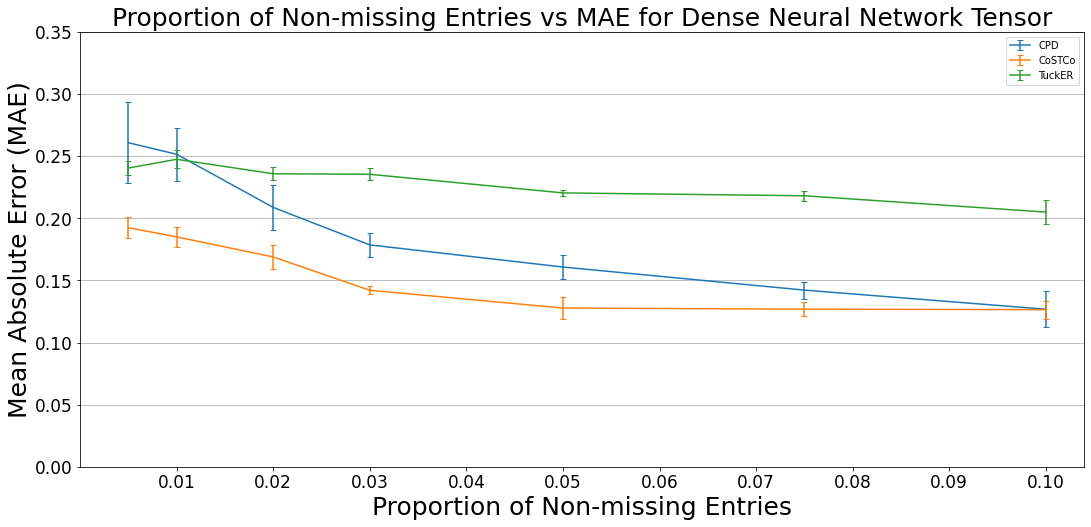

In [ ]:
x = portions

plt.figure(figsize=(18, 8))
# plt.rcParams.update({'font.size':12})

for i in range(len(avgs)):
    plt.errorbar(x, avgs[i], yerr=sds[i], label=labels[i], capsize=3)

plt.xlabel('Proportion of Non-missing Entries', fontsize=25)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=25)
plt.xticks([t/100 for t in range(1, 10+1)], fontsize=17)
# plt.yticks([0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.3, 0.35])
plt.yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35], fontsize = 17)

plt.title(f'Proportion of Non-missing Entries vs MAE for Dense Neural Network Tensor', fontsize=25)
plt.legend()
plt.grid(axis='y')

plt.xlim(0, x[-1]+(x[-1]/25))
# plt.ylim(0.1, 0.2)
# plt.ylim(0, 0.25)
plt.ylim(bottom = 0)

plt.show()